## Nikita Puchkin

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

In [2]:
np.random.seed(1)

### Structure-adaptive manifold estimator

In [3]:
# Manifold denoising procedure
#
# Y -- (n_samples x n_features)-array of noisy observations,
# generated from the model Y_i = X_i + eps_i, 1 <= i <= n_samples,
# where X_i lies on a manifold and eps_i is a perpendicular
# zero-mean noise
#
# projectors_list -- list of initial guesses of projectors
# onto tangent spaces at the points X_1, ..., X_n
#
# bandwidths_list -- a decreasing sequence of bandwidths
#
# d -- manifold dimension
#
# tau -- threshold parameter, must be less than the reach
# of the manifold
#
def SAME(Y, projectors_list, bandwidths_list, d, tau, C=2.0):
    
    # number of iterations
    n_iterations = len(bandwidths_list)
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    
    # Initialization
    X = Y[:,:]
    projectors = projectors_list
    
    for k in range(n_iterations):
        
        # pairwise distances
        dist = pairwise_distances(Y)
        
        # compute adjusted distances
        a_dist = np.empty((0, n))
        for i in range(n):
            
            # distances to the i-th point
            a_dist_i = np.linalg.norm(projectors[i].dot((Y - Y[i,:]).transpose()), axis=0).reshape(1, -1)
            a_dist = np.append(a_dist, a_dist_i, axis=0)
            
        # compute weights
        h = bandwidths_list[k]
        W = np.exp(-a_dist**2/h) * (dist < tau)
        
        # compute the adjusted Nadaraya-Watson estimate
        X = W.dot(Y) / np.tile(np.sum(W, axis=1).reshape(-1, 1), (1, Y.shape[1]))
        
        # compute the projectors
        if k < n_iterations-1:
            for i in range(n):

                # compute weighted covariance
                X0 = X[i, :]
                x_dist = np.linalg.norm(X - X0, axis=1)
                weights = 1 * (x_dist < C * h)
                
                Sigma = np.cov(X.transpose(), aweights=weights)
                u, s, vt = np.linalg.svd(Sigma, full_matrices=False)
                
                # update the i-th projector
                projectors[i] = np.dot(u[:,:d], vt[:d, :])
                
    return X, projectors

### S-shape

In [4]:
n_samples = 1500
noise_level = 0.4

# True values
Z, t = make_s_curve(n_samples, 0, random_state=1)

# Noisy S-curve
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [5]:
n_iterations = 8
a = 1.25
bandwidths = 0.6 * a**(-np.arange(n_iterations))
print(bandwidths)
projectors = [np.identity(3)] * n_samples

[0.6        0.48       0.384      0.3072     0.24576    0.196608
 0.1572864  0.12582912]


In [6]:
X, projectors = SAME(Y, projectors, bandwidths, d=2, tau=0.9)
# compare with the true values
print('Average squared error:', np.linalg.norm(X - Z, ord='fro')**2 / n_samples)        

Average squared error: 0.029321269296639516


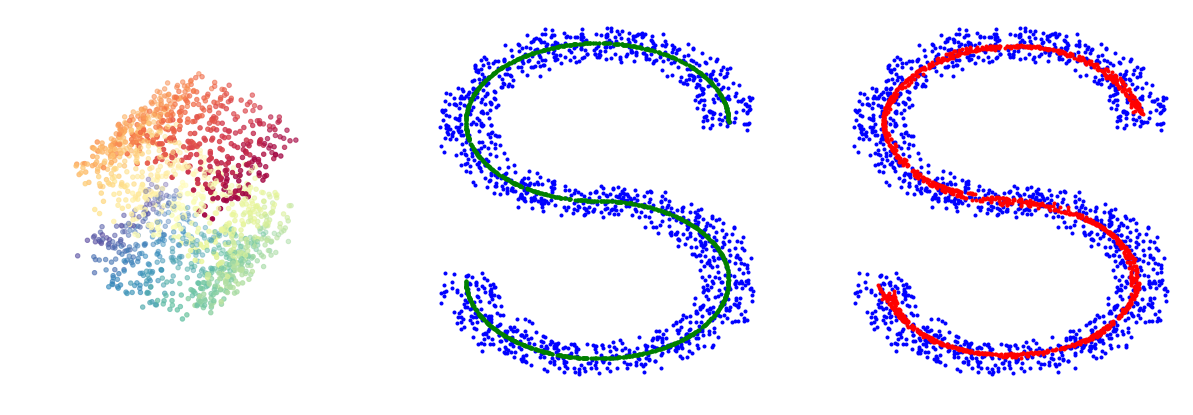

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
#ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=300)
plt.show()
plt.close()

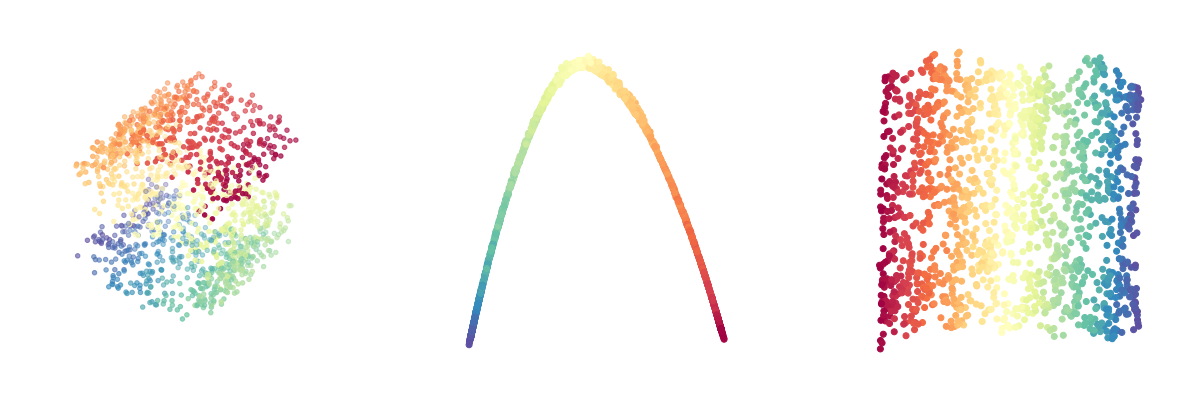

In [8]:
lle = LocallyLinearEmbedding(n_neighbors=15, n_components=2, method='modified')

U = lle.fit_transform(X)
V = lle.fit_transform(Y)

%matplotlib inline

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral)
#ax.set_title("Original noisy data")
ax.axis('off')
ax = fig.add_subplot(132)
ax.scatter(V[:, 0], V[:, 1], c=t, cmap=plt.cm.Spectral)
#ax.set_title('Projected data with LLE only')
ax.axis('off')
ax = fig.add_subplot(133)
ax.scatter(U[:, 0], U[:, 1], c=t, cmap=plt.cm.Spectral)
#ax.set_title('Projected data with ANWE and LLE')
ax.axis('off')
plt.savefig('dim_red_s-shape.png', dpi=300)
plt.show()

### Swiss roll

In [9]:
n_samples = 2500
noise_level = 2.5

# True values
Z, t = make_swiss_roll(n_samples, 0, random_state=1)

# Noisy Swiss Roll
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [10]:
n_iterations = 4
a = 1.25
bandwidths = 3.5 * a**(-np.arange(n_iterations))
print(bandwidths)
projectors = [np.identity(3)] * n_samples

[3.5   2.8   2.24  1.792]


In [11]:
X, projectors = SAME(Y, projectors, bandwidths, d=2, tau=3.5, C=2)
# compare with the true values
print('Average squared error:', np.linalg.norm(X - Z, ord='fro')**2 / n_samples)

Average squared error: 1.1038349524951059


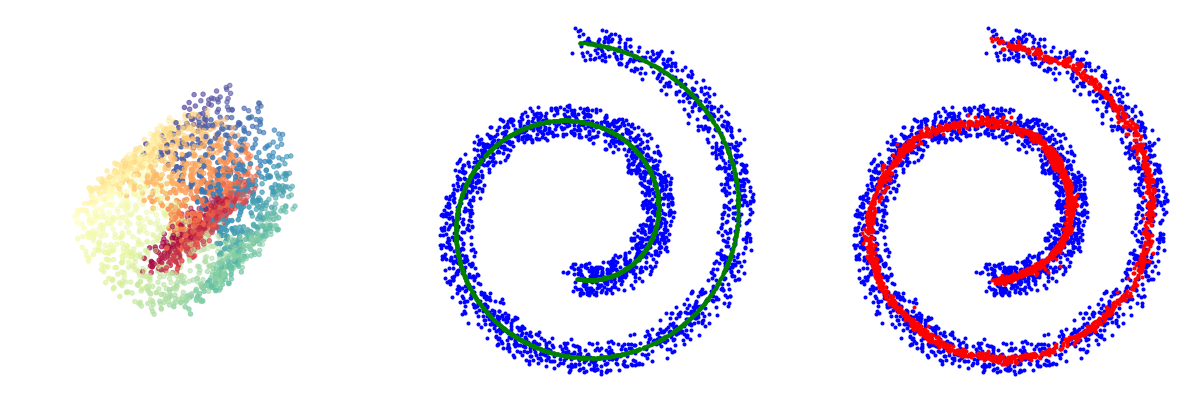

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
#ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
plt.savefig('same_swiss_roll.png', dpi=300)
plt.show()
plt.close()

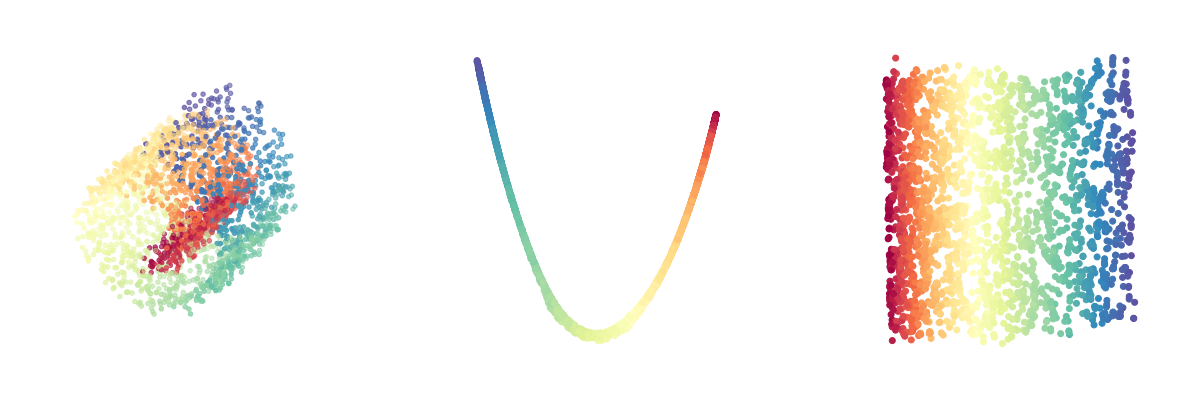

In [13]:
lle = LocallyLinearEmbedding(n_neighbors=15, n_components=2, method='modified')

V = lle.fit_transform(Y)
U = lle.fit_transform(X)

%matplotlib inline

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral)
#ax.set_title("Original noisy data")
ax.axis('off')
ax = fig.add_subplot(132)
ax.scatter(V[:, 0], V[:, 1], c=t, cmap=plt.cm.Spectral)
#ax.set_title('Projected data with LLE only')
ax.axis('off')
ax = fig.add_subplot(133)
ax.scatter(U[:, 0], U[:, 1], c=t, cmap=plt.cm.Spectral)
#ax.set_title('Projected data with ANWE and LLE')
ax.axis('off')
plt.savefig('dim_red_swiss_roll.png', dpi=300)
plt.show()